# Sep 25, 2025: resemblance to canonical systems

conda env: gt

Change facet height to 0.5 while analyzing pi_1_aligned (higher level), while i.e. cols[0:1]. And to 0.35 while analyzing pi_0_aligned (lower level), i.e. while cols[1:2]

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import dill as pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import re
from scipy import stats

import glob
import random

from itertools import product, combinations
import multiprocessing as mp
from functools import partial
from joblib import Parallel, delayed

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from munkres import Munkres

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
from cycler import cycler

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import colorcet as cc

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

In [3]:
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

In [4]:
import seaborn as sns

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [6]:
args.source = 'allen' #'spatial' #'allen'
args.space = 'ccfv2' #'ccfv2'
args.brain_div = 'whl' #'whl'
args.num_rois = 172 #162 #172
args.resolution = 200 #200

PARC_DESC = (
    f'source-{args.source}'
    f'_space-{args.space}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
    f'_res-{args.resolution}'
)
PARC_DESC

'source-allen_space-ccfv2_braindiv-whl_nrois-172_res-200'

In [7]:
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'{os.environ["HOME"]}/new_mouse_dataset'
PARCELS_path = f'{BASE_path}/parcels'
ROI_path = (
    f'{BASE_path}/roi-results-v3'
    f'/{PARC_DESC}'
)
TS_path = f'{ROI_path}/roi_timeseries'

In [8]:
ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
os.system(f'mkdir -p {GRAPH_path}')
SBM_path = f'{ROI_RESULTS_path}/model-fits'
os.system(f'mkdir -p {SBM_path}')
DIAG_path = f'{ROI_RESULTS_path}/diagnostics'
os.system(f'mkdir -p {DIAG_path}')
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.system(f'mkdir -p {ESTIM_path}/individual')
os.system(f'mkdir -p {ESTIM_path}/group')

0

In [9]:
ROI_RESULTS_path_boot = (
    f'{ROI_path}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}-boot'
)
GRAPH_path_boot = f'{ROI_RESULTS_path_boot}/graphs'
os.system(f'mkdir -p {GRAPH_path_boot}')
SBM_path_boot = f'{ROI_RESULTS_path_boot}/model-fits'
os.system(f'mkdir -p {SBM_path_boot}')
DIAG_path_boot = f'{ROI_RESULTS_path_boot}/diagnostics'
os.system(f'mkdir -p {DIAG_path_boot}')
ESTIM_path_boot = f'{ROI_RESULTS_path_boot}/estimates'
os.system(f'mkdir -p {ESTIM_path_boot}/individual')
os.system(f'mkdir -p {ESTIM_path_boot}/group')

0

In [10]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

load membership matrices

In [11]:
indiv_files = sorted(glob.glob(f'{ESTIM_path}/individual/sub-SLC01/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
grp_df = []
for file in indiv_files:
    with open(file, 'rb') as f:
        df = pickle.load(f)
    grp_df += [df]

In [12]:
boot_files = sorted(glob.glob(f'{ESTIM_path_boot}/individual/boot-*/partition-modes-group-aligned/{SBM}/desc-mem-mats.pkl'))
boots_df = []
for file in tqdm(boot_files):
    with open(file, 'rb') as f:
        df = pickle.load(f)
    boots_df += [df]

100%|██████████| 110/110 [00:00<00:00, 846.16it/s]


In [13]:
pis_df = pd.concat(grp_df + boots_df).reset_index(drop=True)
pis_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned,omega
0,grp,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9496124031007752, 0.0, 0.0, 0.0, 0.0503875...","[[0.26990405650233273, 0.6440288789416553, 0.0...","[[0.9201526698804413, 0.06128537650572014, 0.0...","[[0.9878395515527075, 0.009976689198605605, 0....","[[0.9957242760577405, 0.004275723942259544], [...","[[0.997149517371827, 0.0028504826281730293], [...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...",0.257972
1,grp,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9014084507042254, 0.0, 0.03521126760563380...","[[0.2577782484379964, 0.6056505825165969, 0.10...","[[0.9229028897536316, 0.04418924874364539, 0.0...","[[0.9832180171575026, 0.009469124730781155, 0....","[[0.998171785472071, 0.0, 0.001828214527929052...","[[0.998171785472071, 0.0, 0.001828214527929052...","[[0.998171785472071, 0.0018282145279290526], [...","[[1.0], [0.9999999999999999], [1.0], [1.0], [1...",0.141756
2,grp,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9603174603174603, 0.0, 0.02380952380952380...","[[0.062295288485764676, 0.837962962962963, 0.0...","[[0.990532053055227, 0.0034393706396990465, 0....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",0.126375
3,grp,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.15702479338842976, 0.768595041322314, 0.06...","[[0.8881112654215585, 0.10046874960473759, 0.0...","[[0.998572501878287, 0.0, 0.001427498121712997...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....",0.121384
4,grp,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.974025974025974, 0.0, 0.025974025974025976...","[[0.6071850227694383, 0.27862602196163366, 0.0...","[[0.9291409601437918, 0.015660401422622795, 0....","[[0.9874163597969866, 0.0046981204267868395, 0...","[[0.9905484400815112, 0.00156604014226228, 0.0...","[[0.9921144802237735, 0.0, 0.00788551977622647...","[[0.9921144802237735, 0.00788551977622647], [0...","[[0.9921144802237735, 0.00788551977622647], [0...",0.076945
...,...,...,...,...,...,...,...,...,...,...,...,...
1271,89,sbm-nd-h,"[[0.975609756097561, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.8958754709498316, 0.023795359904818562, 0....","[[0.0808199036613937, 0.8079089746876055, 0.08...","[[0.9531361388326043, 0.04109101090586787, 0.0...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...","[[1.0000000000000002], [0.9999999999999999], [...",0.040787
1272,89,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.42105263157894735, 0.0, 0.5789473684210527...","[[0.060403200984918436, 0.9013542628501078, 0....","[[0.9708477102266285, 0.029152289773371563], [...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...","[[1.0], [1.0], [0.9999999999999999], [1.0], [1...",0.038413
1273,89,sbm-nd-h,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.12903225806451613, 0.0, 0.8709677419354839...","[[0.008324661810613945, 0.9146722164412071, 0....","[[0.9990750375765985, 0.0, 0.00092496242340154...","[[1.0], [1.0], [1.0], [1.0000000000000002], [1...","[[1.0], [1.0], [1.0], [1.0000000000000002], [1...","[[1.0], [1.0], [1.0], [1.0000000000000

In [14]:
def make_same_shape(Ms: list):
    num_rois = Ms[0].shape[0]
    num_comms = [M.shape[-1] for M in Ms]
    max_comms = np.max(num_comms)
    Rs = np.zeros((len(Ms), num_rois, max_comms))
    for idx, M in enumerate(Ms):
        Rs[idx, :, :M.shape[-1]] = M
    Rs = [Rs[idx, :, :] for idx in range(Rs.shape[0])]
    return Rs

In [15]:
cols = [c for c in pis_df.columns if 'pi' in c]

In [16]:
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols].apply(lambda pis: make_same_shape(pis.to_list())),
    ],
    axis=1
)

In [17]:
def keep_select_comms(args: ARGS, Ms: list):
    Ms = np.stack(Ms)
    Ms = Ms[:, :, args.select_comms]
    return [Ms[i, :, :] for i in range(Ms.shape[0])]

In [18]:
args.select_comms = np.arange(0, 9) # for pi_1_aligned only
i = 1
cols1 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) < i]
cols2 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) > i]
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols1],
        pis_df[cols[i:i+1]].apply(lambda pis: keep_select_comms(args, pis.to_list())),
        pis_df[cols2],
    ],
    axis=1
)

In [19]:
args.select_comms = np.arange(0, 23) # for pi_0_aligned only
i = 0
cols1 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) < i]
cols2 = [c for c in cols if int(c.replace('pi_', '').replace('_aligned', '')) > i]
pis_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols1],
        pis_df[cols[i:i+1]].apply(lambda pis: keep_select_comms(args, pis.to_list())),
        pis_df[cols2],
    ],
    axis=1
)

In [20]:
pis_df

,sub,sbm,omega,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,grp,sbm-nd-h,0.257972,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9496124031007752, 0.0, 0.0, 0.0, 0.0503875...","[[0.26990405650233273, 0.6440288789416553, 0.0...","[[0.9201526698804413, 0.06128537650572014, 0.0...","[[0.9878395515527075, 0.009976689198605605, 0....","[[0.9957242760577405, 0.004275723942259544, 0....","[[0.997149517371827, 0.0028504826281730293, 0....","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999..."
1,grp,sbm-nd-h,0.141756,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9014084507042254, 0.0, 0.03521126760563380...","[[0.2577782484379964, 0.6056505825165969, 0.10...","[[0.9229028897536316, 0.04418924874364539, 0.0...","[[0.9832180171575026, 0.009469124730781155, 0....","[[0.998171785472071, 0.0, 0.001828214527929052...","[[0.998171785472071, 0.0, 0.001828214527929052...","[[0.998171785472071, 0.0018282145279290526, 0....","[[1.0, 0.0, 0.0], [0.9999999999999999, 0.0, 0...."
2,grp,sbm-nd-h,0.126375,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.9603174603174603, 0.0, 0.02380952380952380...","[[0.062295288485764676, 0.837962962962963, 0.0...","[[0.990532053055227, 0.0034393706396990465, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
3,grp,sbm-nd-h,0.121384,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]...","[[0.15702479338842976, 0.768595041322314, 0.06...","[[0.8881112654215585, 0.10046874960473759, 0.0...","[[0.998572501878287, 0.0, 0.001427498121712997...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ..."
4,grp,sbm-nd-h,0.076945,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.974025974025974, 0.0, 0.025974025974025976...","[[0.6071850227694383, 0.27862602196163366, 0.0...","[[0.9291409601437918, 0.015660401422622795, 0....","[[0.9874163597969866, 0.0046981204267868395, 0...","[[0.9905484400815112, 0.00156604014226228, 0.0...","[[0.9921144802237735, 0.0, 0.00788551977622647...","[[0.9921144802237735, 0.00788551977622647, 0.0...","[[0.9921144802237735, 0.00788551977622647, 0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1271,89,sbm-nd-h,0.040787,"[[0.975609756097561, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.8958754709498316, 0.023795359904818562, 0....","[[0.0808199036613937, 0.8079089746876055, 0.08...","[[0.9531361388326043, 0.04109101090586787, 0.0...","[[1.0000000000000002, 0.0, 0.0, 0.0], [0.99999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999...","[[1.0000000000000002, 0.0, 0.0], [0.9999999999..."
1272,89,sbm-nd-h,0.038413,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.42105263157894735, 0.0, 0.5789473684210527...","[[0.060403200984918436, 0.9013542628501078, 0....","[[0.9708477102266285, 0.029152289773371563, 0....","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.99999999..."
1273,89,sbm-nd-h,0.030960,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.12903225806451613, 0.0, 0.8709677419354839...","[[0.008324661810613945, 0.9146722164412071, 0....","[[0.9990750375765985, 0.0, 0.00092496242340154...","[[1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 0.0], [...","[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, ...","[[1.0, 0.0, 0.0], [1.0, 0.0, 

load canonical systems

In [21]:
ROI_SYS_path = f'{ROI_path}/canonical-systems/joanes'
X = np.loadtxt(f'{ROI_SYS_path}/desc-roi-rsns-mat.csv') # n_rois x n_rsns
v = np.loadtxt(f'{ROI_SYS_path}/desc-roi-vox-counts.csv') # n_rois
num_sys = X.shape[1]
num_sys

6

specificity

In [22]:
def specificity_matrix(X, Y, v):
    Yv = Y * v[:, np.newaxis]
    numerator = X.T @ Yv 
    denominator = Yv.sum(axis=0)
    S = numerator / denominator
    S = np.nan_to_num(S)
    S = np.round(S, decimals=3)
    return S

In [23]:
specificity_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols].applymap(lambda Y: specificity_matrix(X, Y, v))
    ],
    axis=1,
)

In [24]:
specificity_df

,sub,sbm,omega,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,grp,sbm-nd-h,0.257972,"[[0.0, 1.0, 0.0, 0.933, 0.865, 0.097, 0.034, 0...","[[0.0, 0.958, 0.049, 0.056, 0.06, 0.018, 0.0, ...","[[0.022, 0.265, 0.009, 0.0, 0.0, 0.0, 0.685, 0...","[[0.107, 0.128, 0.04, 0.0, 0.0, 0.0, 0.0], [0....","[[0.107, 0.128, 0.04, 0.0], [0.081, 0.086, 0.0...","[[0.107, 0.128, 0.0], [0.081, 0.086, 0.0], [0....","[[0.107, 0.128, 0.0], [0.081, 0.086, 0.0], [0....","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,..."
1,grp,sbm-nd-h,0.141756,"[[0.0, 1.0, 0.0, 0.933, 0.792, 0.092, 0.0, 0.0...","[[0.0, 0.938, 0.08, 0.063, 0.03, 0.018, 0.0, 0...","[[0.026, 0.29, 0.016, 0.0, 0.0, 0.0, 0.938, 0....","[[0.109, 0.148, 0.026, 0.0, 0.0, 0.0, 0.0], [0...","[[0.107, 0.148, 0.026, 0.0], [0.081, 0.086, 0....","[[0.107, 0.0, 0.026], [0.081, 0.0, 0.09], [0.1...","[[0.107, 0.0, 0.026], [0.081, 0.0, 0.09], [0.1...","[[0.107, 0.026, 0.0], [0.081, 0.09, 0.0], [0.1...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,..."
2,grp,sbm-nd-h,0.126375,"[[0.0, 1.0, 0.0, 0.933, 0.808, 0.087, 0.0, 0.0...","[[0.0, 0.903, 0.052, 0.051, 0.058, 0.011, 0.0,...","[[0.198, 0.115, 0.051, 0.002, 0.0, 0.0, 0.903,...","[[0.107, 0.002, 0.198, 0.0, 0.0, 0.0, 0.0], [0...","[[0.107, 0.0, 0.0, 0.0], [0.081, 0.0, 0.0, 0.0...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,..."
3,grp,sbm-nd-h,0.121384,"[[0.0, 1.0, 0.001, 0.933, 0.744, 0.067, 0.039,...","[[0.0, 0.934, 0.084, 0.037, 0.046, 0.019, 0.0,...","[[0.014, 0.234, 0.003, 0.0, 0.0, 0.0, 0.046, 0...","[[0.106, 0.137, 0.014, 0.0, 0.0, 0.0, 0.0], [0...","[[0.107, 0.0, 0.014, 0.0], [0.081, 0.0, 0.039,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,..."
4,grp,sbm-nd-h,0.076945,"[[0.0, 1.0, 0.0, 0.933, 0.831, 0.093, 0.0, 0.0...","[[0.001, 0.937, 0.086, 0.068, 0.013, 0.019, 0....","[[0.02, 0.35, 0.023, 0.0, 0.0, 0.0, 0.0, 0.001...","[[0.11, 0.103, 0.02, 0.0, 0.0, 0.0, 0.0], [0.0...","[[0.107, 0.103, 0.02, 0.0], [0.082, 0.058, 0.0...","[[0.107, 0.103, 0.02], [0.081, 0.058, 0.085], ...","[[0.107, 0.0, 0.02], [0.081, 0.0, 0.085], [0.1...","[[0.107, 0.02, 0.0], [0.081, 0.085, 0.0], [0.1...","[[0.107, 0.02, 0.0], [0.081, 0.085, 0.0], [0.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1271,89,sbm-nd-h,0.040787,"[[0.0, 1.0, 0.003, 0.911, 0.74, 0.011, 0.116, ...","[[0.006, 0.842, 0.075, 0.16, 0.046, 0.029, 0.0...","[[0.344, 0.094, 0.011, 0.0, 0.0, 0.0, 0.0, 0.0...","[[0.107, 0.061, 0.344, 0.0, 0.0, 0.0, 0.0], [0...","[[0.107, 0.0, 0.0, 0.0], [0.081, 0.0, 0.0, 0.0...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,..."
1272,89,sbm-nd-h,0.038413,"[[0.0, 1.0, 0.009, 0.933, 0.804, 0.092, 0.124,...","[[0.031, 0.602, 0.049, 0.349, 0.149, 0.001, 0....","[[0.372, 0.051, 0.01, 0.0, 0.0, 0.0, 0.0, 0.03...","[[0.109, 0.028, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0...","[[0.107, 0.0, 0.0, 0.0], [0.081, 0.0, 0.0, 0.0...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,..."
1273,89,sbm-nd-h,0.030960,"[[0.0, 1.0, 0.005, 0.84, 0.771, 0.046, 0.102, ...","[[0.034, 0.584, 0.073, 0.312, 0.163, 0.012, 0....","[[0.321, 0.102, 0.042, 0.002, 0.0, 0.0, 0.0, 0...","[[0.104, 0.0, 0.321, 0.0, 0.0, 0.0, 0.0], [0.0...","[[0.107, 0.0, 0.0, 0.0], [0.081, 0.0, 0.0, 0.0...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0

In [25]:
def get_soft_estim_df(estim_df: pd.DataFrame):
    soft_estim_df = []
    for sub, group in estim_df.groupby('sub'):
        omegas = group['omega']
        dct = {'sub':[sub], 'sbm':[SBM]}
        for col in cols:
            X = group[col].to_list()
            soft_X = np.average(X, axis=0, weights=omegas)
            dct[col] = [soft_X]
        soft_estim_df += [pd.DataFrame(dct)]
    soft_estim_df = pd.concat(soft_estim_df).reset_index(drop=True)
    return soft_estim_df

In [26]:
soft_specificity_df = get_soft_estim_df(specificity_df)
soft_specificity_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,00,sbm-nd-h,"[[0.0, 0.9998088817763554, 0.05670530106021206...","[[0.018678087617523504, 0.6891929585917185, 0....","[[0.07509334666933387, 0.1775791558311662, 0.0...","[[0.10778366873374677, 0.072798199639928, 0.06...","[[0.10729501100220043, 0.0213056851370274, 0.0...","[[0.10705014602920582, 0.0, 0.0224277335467093...","[[0.10702280456091215, 0.0, 0.0160058411682336...","[[0.10699999999999997, 0.012608985797159432, 0...","[[0.10699999999999997, 0.0, 0.0], [0.081, 0.0,..."
1,01,sbm-nd-h,"[[0.0, 0.756, 0.01, 0.683, 0.829, 0.106, 0.155...","[[0.17, 0.417, 0.327, 0.196, 0.22, 0.005, 0.0,...","[[0.097, 0.129, 0.111, 0.01, 0.0, 0.0, 0.407, ...","[[0.108, 0.052, 0.097, 0.0, 0.0, 0.0, 0.0], [0...","[[0.107, 0.052, 0.097, 0.0], [0.081, 0.041, 0....","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,..."
2,02,sbm-nd-h,"[[0.0, 0.9995807641528306, 0.00364668133626725...","[[0.001738355671134227, 0.6169055411082217, 0....","[[0.2714721824364873, 0.11732183236647331, 0.0...","[[0.10792727345469093, 0.010323472694538907, 0...","[[0.10714039607921584, 0.007600800160032006, 0...","[[0.10699999999999998, 0.0, 0.0], [0.081, 0.0,...","[[0.10699999999999998, 0.0, 0.0], [0.081, 0.0,...","[[0.10699999999999998, 0.0, 0.0], [0.081, 0.0,...","[[0.10699999999999998, 0.0, 0.0], [0.081, 0.0,..."
3,03,sbm-nd-h,"[[0.0, 1.0000000000000002, 0.00639292800000000...","[[0.011925032, 0.6580063119999998, 0.087056176...","[[0.229664224, 0.16016554400000005, 0.02964335...","[[0.10849890400000003, 0.06248703200000001, 0....","[[0.1070138, 0.042786000000000005, 0.038722296...","[[0.10700000000000003, 0.014120848000000002, 0...","[[0.10700000000000003, 0.0, 0.0], [0.081000000...","[[0.10700000000000003, 0.0, 0.0], [0.081000000...","[[0.10700000000000003, 0.0, 0.0], [0.081000000..."
4,04,sbm-nd-h,"[[0.0, 0.999, 0.003, 0.827, 0.782, 0.01, 0.117...","[[0.003, 0.674, 0.061, 0.113, 0.101, 0.008, 0....","[[0.254, 0.11, 0.066, 0.003, 0.0, 0.0, 0.577, ...","[[0.108, 0.049, 0.254, 0.0, 0.0, 0.0, 0.0], [0...","[[0.107, 0.049, 0.254, 0.0], [0.081, 0.046, 0....","[[0.107, 0.049, 0.254], [0.081, 0.046, 0.126],...","[[0.107, 0.049, 0.0], [0.081, 0.046, 0.0], [0....","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,...","[[0.107, 0.0, 0.0], [0.081, 0.0, 0.0], [0.149,..."
...,...,...,...,...,...,...,...,...,...,...,...
106,84,sbm-nd-h,"[[0.0, 0.9998695339067813, 0.00146327932253117...","[[0.028372381142895243, 0.5330616790024671, 0....","[[0.05333809428552377, 0.20764632926585322, 0....","[[0.10623530039341202, 0.11449499233179972, 0....","[[0.10672255784490231, 0.10365490431419619, 0....","[[0.10676819363872773, 0.06205417083416684, 0....","[[0.107, 0.04399119823964793, 0.00218587717543...","[[0.107, 0.0, 0.04399119823964793], [0.0810000...","[[0.107, 0.0, 0.0], [0.08100000000000002, 0.0,..."
107,85,sbm-nd-h,"[[0.0, 1.0, 0.1167384769138517, 0.403093477246...","[[0.014586741288560193, 0.6405304817109735, 0....","[[0.09631732960223865, 0.14828897328269702, 0....","[[0.10816093010860149, 0.06920185222200013, 0....","[[0.10712300619628222, 0.0423663535212206, 0.0...","[[0.10699999999999998, 0.0048944499966686655, ...","[[0.10699999999999998, 0.0048944499966686655, ...","[[0.10699999999999998, 0.0, 0.0], [0.080999999...","[[0.10699999999999998, 0.0, 0.0], [0.080999999..."
108,87,sbm-nd-h,"[[0.0, 1.0, 0.11442373808094951, 0.14394710942...","[[0.05663870107354803, 0.5610439287857573, 0.1...","[[0.22542715209708603, 0.13361564312862567, 0....","[[0.10741887044075478, 0.05379642595185701, 0....","[[0.10701265586450621, 0.028096472627858898, 0...","[[0.10699999999999997, 0.012214842968593714, 0...","[[0.10699999999999997, 0.0, 0.0], [0.080999999...","[[0.10699999999999997, 0.0, 0.0], [0.080999999...","[[0.10699999999

In [27]:
def make_tidy(estim_df: pd.DataFrame, col: str):
    mats_list = []
    for idx, mat in enumerate(estim_df[col]):
        rs, cs = np.indices(mat.shape)
        temp_df = pd.DataFrame({
            'i':rs.flatten(),
            'j':cs.flatten(),
            'value':mat.flatten(),
            'sample':idx,
        })
        mats_list += [temp_df]
    long_df = pd.concat(mats_list, ignore_index=True)
    return long_df

In [28]:
def plot_specificities(long_df: pd.DataFrame):
    ncols = sorted(long_df['i'].unique())
    ncols = len(ncols)
    nrows = sorted(long_df['j'].unique())
    nrows = len(nrows)

    height = 0.5 #inches
    aspect = 1
    width = height * aspect

    fig_height = height * nrows
    fig_width = width * ncols

    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height), 
        sharey=True
    )
    # Manually set the spacing. Values are fractions of the figure dimensions.
    # This guarantees identical spacing for every figure you create this way.
    fig.subplots_adjust(
        left=0.1,    # Increase if y-axis labels are cut off
        right=0.9,   # Decrease if there's too much margin on the right
        bottom=0.1,  # Increase if x-axis labels are cut off
        top=0.9,     # Decrease if titles are cut off
        wspace=0.3, # Width between subplots
        hspace=0.3,   # Height between subplots
    )

    for (i, j), group in long_df.groupby(by=['i', 'j']):
        
        ax = axs[j, i] if nrows > 1 else axs[i]
        
        sns.boxplot(
            group, 
            ax=ax,
            y='value',
            color='grey',
            fill=False,
            width=0.5,
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax, 
            y='value',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5,
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        ax.set(ylim=[0, 1], yticks=[0, 1], )
        # ax.set(ylim=[0, 1], yticks=[0, 0.5, 1], xlabel=None, ylabel=None)
        if j == 0: ax.set_title(f'RSN {i+1}')
        if i == 0: ax.set_ylabel(f'C. {j+1:02d}')
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

pi_1_aligned


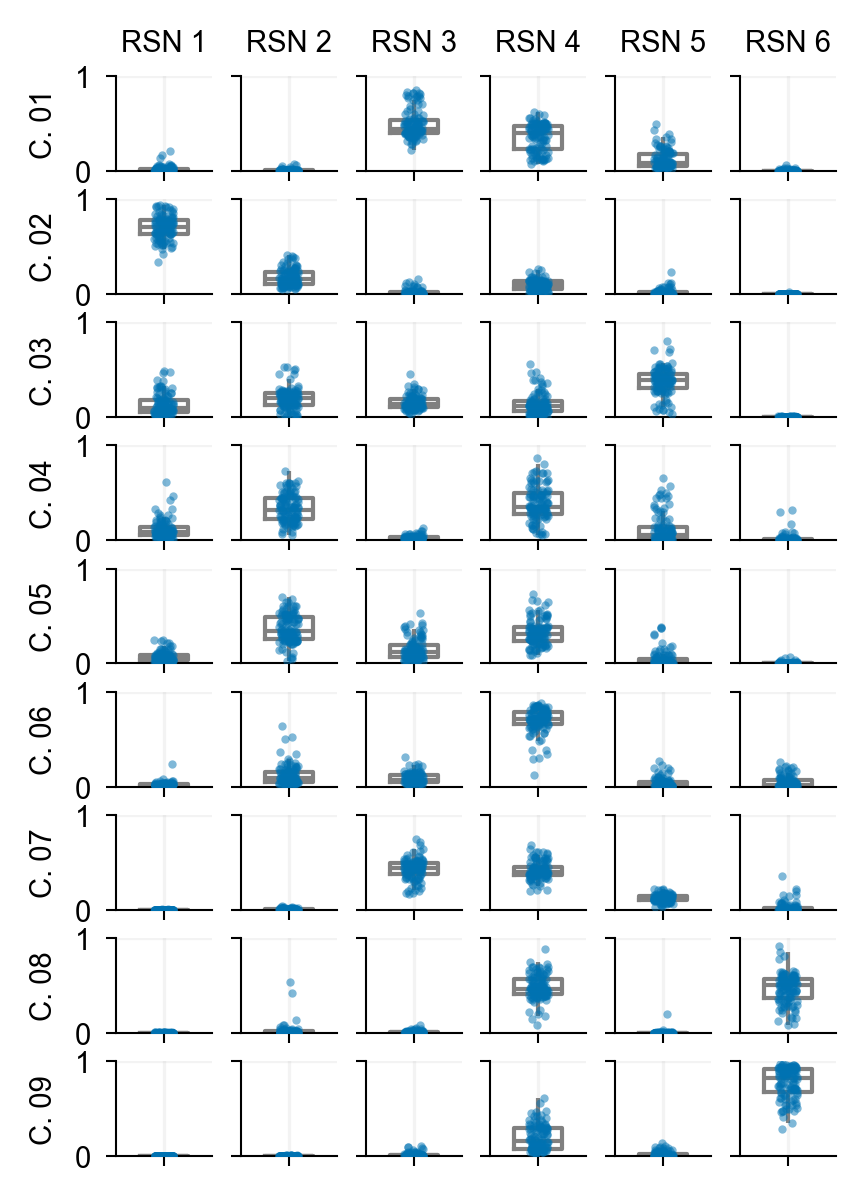

In [29]:
folder = f'{ESTIM_path}/group/resemblance-to-rsns/{SBM}'
os.makedirs(folder, exist_ok=True)

for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    long_df = make_tidy(soft_specificity_df, col)
    g = plot_specificities(long_df)
    g.savefig(f'{folder}/level-{level}_desc-specificities.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/level-{level}_desc-specificities.png', transparent=True, dpi=300, bbox_inches='tight')

effective number of RSNs spanned by a comm.

In [30]:
def eff_num_rsns(S):
    Ers = np.exp(stats.entropy(S, axis=0))
    Ers = np.nan_to_num(Ers)[None, :]
    return Ers

In [31]:
eff_num_rsns_df = pd.concat(
    [
        specificity_df[['sub', 'sbm', 'omega']],
        specificity_df[cols].applymap(lambda S: eff_num_rsns(S)),
    ],
    axis=1,
)

soft_eff_num_rsns_df = get_soft_estim_df(eff_num_rsns_df)

soft_eff_num_rsns_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,00,sbm-nd-h,"[[1.0485787528570325, 1.001375887542335, 1.262...","[[2.931955714791565, 2.4016499073639586, 3.381...","[[4.036657650545746, 5.375185237562598, 3.6250...","[[5.210346563677169, 4.0801415626673805, 3.544...","[[5.204555897041222, 1.4200588731375554, 1.631...","[[5.202028412735351, 0.0, 1.1204778113864833]]","[[5.201660498418723, 0.0, 0.7560876301481018]]","[[5.201121112082051, 0.4880887137399369, 0.0]]","[[5.201121112082051, 0.0, 0.0]]"
1,01,sbm-nd-h,"[[1.7773766346653, 2.0510912392606766, 1.87442...","[[4.091646752749984, 3.5201771361783205, 3.925...","[[5.021095547544677, 5.43247393614278, 5.33267...","[[5.219337516756274, 4.389663903460269, 5.0210...","[[5.201121112082052, 4.389663903460269, 5.0210...","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]"
2,02,sbm-nd-h,"[[1.833448838366055, 1.0024246076201575, 0.169...","[[2.339336176955794, 2.2973350540560986, 2.895...","[[4.639887840158027, 5.309960324210232, 1.6376...","[[5.215773168199595, 3.395770145475736, 3.3855...","[[5.203825577801362, 1.218550218444657, 2.8210...","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]"
3,03,sbm-nd-h,"[[1.586854431306835, 1.0000000000000002, 1.032...","[[2.364693673353907, 2.1949627778512446, 2.786...","[[4.196528507010429, 5.169675790676627, 4.0689...","[[5.213752652420825, 4.649123085107837, 3.5361...","[[5.202179182617077, 3.383611608957253, 0.9023...","[[5.201475621086982, 0.868660790832736, 0.0]]","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]"
4,04,sbm-nd-h,"[[1.745035879420783, 1.0079386000168544, 1.365...","[[2.506312500109418, 2.5668922424150886, 4.102...","[[4.913828571183162, 5.293958727670355, 4.8890...","[[5.213291553976821, 4.582307643312867, 4.9138...","[[5.201545742754161, 4.582307643312867, 4.9138...","[[5.201121112082052, 4.582307643312867, 4.9138...","[[5.201121112082052, 4.582307643312867, 0.0]]","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]"
...,...,...,...,...,...,...,...,...,...,...,...
106,84,sbm-nd-h,"[[1.3317068295002277, 1.0010357181298244, 1.95...","[[2.6807073406509936, 2.8680465842125042, 4.16...","[[3.6649301463358963, 5.099263932062719, 3.524...","[[5.1950135206935215, 4.8085732132875645, 2.96...","[[5.198280577465338, 3.774085710164446, 0.3455...","[[5.199297290385465, 1.850816599169077, 0.3455...","[[5.2013156325244125, 1.224544416886555, 0.227...","[[5.201121112082053, 0.0, 1.224544416886555]]","[[5.201121112082053, 0.0, 0.0]]"
107,85,sbm-nd-h,"[[1.4437013680118918, 1.0, 1.5807477298553023,...","[[2.8719541371322554, 2.6076674685531613, 3.85...","[[4.1942425403848365, 5.301597655974134, 4.009...","[[5.215773651282616, 4.398571730010214, 4.1421...","[[5.2032241771328795, 2.6877982688674638, 1.43...","[[5.2011635270533105, 0.38801799661357544, 1.0...","[[5.201293956806935, 0.38801799661357544, 0.0]]","[[5.201121112082051, 0.0, 0.0]]","[[5.201121112082051, 0.0, 0.0]]"
108,87,sbm-nd-h,"[[1.010289656784549, 1.0, 1.6728445639114808, ...","[[3.0093788603109184, 3.0531115548826406, 4.04...","[[4.468414772546061, 5.3736478192257024, 2.988...","[[5.20826995154148, 3.934220318572735, 4.18876...","[[5.201994062541089, 1.7496743317674728, 1.411...","[[5.201299521880495, 0.6663830659658194, 0.185...","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]","[[5.201121112082052, 0.0, 0.0]]"
109,89,sbm-nd-h,"[[1.0016623989231181, 1.0052302302119227, 1.13...","[[2.8722570701021986, 2.410958642184871, 3.288...","[[3.9806951414980656, 4.728433620939165, 3.212...","[[5.202905487481512, 4.352774609245144, 3.7406...","[[5.201232141608287, 2.823162195850405, 0.7451...","[[5.201194737378852, 0.7567663431766787, 0.0]]","[[5.201121112082051, 

In [44]:
def plot_eff_num_rsns(long_df: pd.DataFrame, ):
    nrows = sorted(long_df['j'].unique())
    nrows = len(nrows)
    ncols = 1

    height = 0.5 #inches
    aspect = 1
    width = height * aspect

    fig_height = height * nrows
    fig_width = width * ncols

    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height), 
        sharey=False,
    )
    # Manually set the spacing. Values are fractions of the figure dimensions.
    # This guarantees identical spacing for every figure you create this way.
    fig.subplots_adjust(
        left=0.1,    # Increase if y-axis labels are cut off
        right=0.9,   # Decrease if there's too much margin on the right
        bottom=0.1,  # Increase if x-axis labels are cut off
        top=0.9,     # Decrease if titles are cut off
        wspace=0.3, # Width between subplots
        hspace=0.3,   # Height between subplots
    )

    for (i, j), group in long_df.groupby(by=['i', 'j']):
        
        ax = axs[j, i] if ncols > 1 else axs[j]
        
        sns.boxplot(
            group, 
            ax=ax,
            y='value',
            color='grey',
            fill=False,
            width=0.5,
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax, 
            y='value',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5,
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        ax.set(ylabel=f'C. {j+1:02d}') #, ylim=[1, 5], yticks=[1, 2, 3, 4, 5], xlabel=None, ylabel=None)
        # ax.set(ylim=[1, 5], yticks=[1, 3, 5])
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

pi_1_aligned


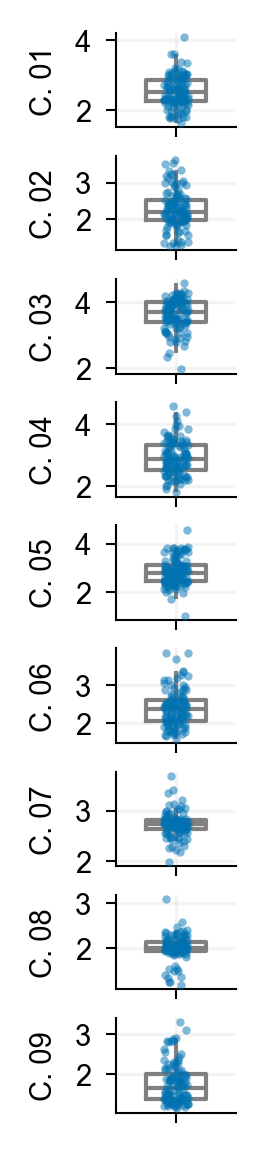

In [45]:
folder = f'{ESTIM_path}/group/resemblance-to-rsns/{SBM}'
os.makedirs(folder, exist_ok=True)

for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    long_df = make_tidy(soft_eff_num_rsns_df, col)
    g = plot_eff_num_rsns(long_df)
    g.savefig(f'{folder}/level-{level}_desc-eff-num-rsns.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/level-{level}_desc-eff-num-rsns.png', transparent=True, dpi=300, bbox_inches='tight')

coverage

In [34]:
def coverage_matrix(X, Y, v):
    Xv = X * v[:, np.newaxis]
    numerator = Y.T @ Xv 
    denominator = Xv.sum(axis=0)
    U = numerator / denominator
    U = np.nan_to_num(U)
    U = np.round(U, decimals=3)
    return U

In [35]:
coverage_df = pd.concat(
    [
        pis_df[['sub', 'sbm', 'omega']],
        pis_df[cols].applymap(lambda Y: coverage_matrix(X, Y, v))
    ],
    axis=1,
)

In [36]:
coverage_df

,sub,sbm,omega,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,grp,sbm-nd-h,0.257972,"[[0.0, 0.0, 0.166, 0.0, 0.0, 0.0], [0.539, 0.0...","[[0.0, 0.0, 0.43, 0.213, 0.041, 0.0], [0.882, ...","[[0.056, 0.228, 0.48, 0.435, 0.171, 0.044], [0...","[[0.921, 0.92, 0.922, 0.925, 0.919, 0.916], [0...","[[0.987, 0.988, 0.989, 0.989, 0.988, 0.986], [...","[[0.995, 0.996, 0.997, 0.997, 0.995, 0.994], [...","[[0.997, 0.997, 0.998, 0.998, 0.997, 0.996], [...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
1,grp,sbm-nd-h,0.141756,"[[0.0, 0.0, 0.166, 0.0, 0.0, 0.0], [0.548, 0.0...","[[0.0, 0.0, 0.416, 0.198, 0.039, 0.0], [0.831,...","[[0.071, 0.329, 0.514, 0.459, 0.19, 0.018], [0...","[[0.939, 0.917, 0.902, 0.91, 0.928, 0.955], [0...","[[0.987, 0.982, 0.978, 0.98, 0.984, 0.99], [0....","[[0.999, 0.998, 0.996, 0.997, 0.999, 1.0], [0....","[[0.999, 0.998, 0.996, 0.997, 0.999, 1.0], [0....","[[0.999, 0.998, 0.996, 0.997, 0.999, 1.0], [0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
2,grp,sbm-nd-h,0.126375,"[[0.0, 0.0, 0.166, 0.0, 0.0, 0.0], [0.553, 0.0...","[[0.0, 0.0, 0.436, 0.211, 0.041, 0.0], [0.879,...","[[0.095, 0.046, 0.076, 0.062, 0.025, 0.007], [...","[[0.991, 0.995, 0.989, 0.99, 0.996, 0.992], [0...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
3,grp,sbm-nd-h,0.121384,"[[0.0, 0.0, 0.166, 0.0, 0.0, 0.0], [0.542, 0.0...","[[0.0, 0.0, 0.44, 0.215, 0.042, 0.0], [0.847, ...","[[0.036, 0.129, 0.469, 0.419, 0.192, 0.066], [...","[[0.894, 0.894, 0.902, 0.903, 0.898, 0.897], [...","[[1.0, 0.999, 0.996, 0.996, 0.998, 0.999], [0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
4,grp,sbm-nd-h,0.076945,"[[0.0, 0.0, 0.164, 0.0, 0.0, 0.0], [0.544, 0.0...","[[0.001, 0.0, 0.431, 0.21, 0.05, 0.0], [0.862,...","[[0.064, 0.351, 0.641, 0.522, 0.197, 0.0], [0....","[[0.958, 0.941, 0.928, 0.923, 0.951, 0.922], [...","[[0.988, 0.987, 0.988, 0.984, 0.988, 0.977], [...","[[0.996, 0.993, 0.99, 0.99, 0.994, 0.992], [0....","[[0.999, 0.995, 0.992, 0.993, 0.997, 1.0], [0....","[[0.999, 0.995, 0.992, 0.993, 0.997, 1.0], [0....","[[0.999, 0.995, 0.992, 0.993, 0.997, 1.0], [0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
1271,89,sbm-nd-h,0.040787,"[[0.0, 0.0, 0.15, 0.0, 0.0, 0.0], [0.575, 0.0,...","[[0.007, 0.0, 0.421, 0.186, 0.104, 0.0], [0.78...","[[0.471, 0.301, 0.075, 0.132, 0.093, 0.02], [0...","[[0.941, 0.946, 0.944, 0.948, 0.947, 0.938], [...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
1272,89,sbm-nd-h,0.038413,"[[0.0, 0.0, 0.166, 0.0, 0.0, 0.0], [0.542, 0.0...","[[0.034, 0.0, 0.327, 0.113, 0.263, 0.0], [0.71...","[[0.77, 0.721, 0.064, 0.165, 0.049, 0.036], [0...","[[0.994, 0.991, 0.971, 0.971, 0.97, 0.971], [0...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
1273,89,sbm-nd-h,0.030960,"[[0.0, 0.0, 0.167, 0.0, 0.0, 0.0], [0.553, 0.0...","[[0.033, 0.0, 0.324, 0.062, 0.307, 0.0], [0.70...","[[0.365, 0.342, 0.051, 0.11, 0.034, 0.023], [0...","[[0.959, 0.962, 0.994, 0.988, 0.996, 0.997], [...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [37]:
soft_coverage_df = get_soft_estim_df(coverage_df)
soft_coverage_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,00,sbm-nd-h,"[[0.0, 0.0, 0.1228571874374875, 0.000468237647...","[[0.033213458691738355, 0.003375251050210042, ...","[[0.10937793158631727, 0.1797023484696939, 0.2...","[[0.9566426805361072, 0.953603016603321, 0.947...","[[0.9945678735747153, 0.9930241408281658, 0.99...","[[0.9990943628725748, 0.9984683576715346, 0.99...","[[0.9994659651930387, 0.9991166073214643, 0.99...","[[0.9997044768953792, 0.9996059691938389, 0.99...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
1,01,sbm-nd-h,"[[0.0, 0.0, 0.14, 0.021, 0.0, 0.0], [0.245, 0....","[[0.101, 0.007, 0.134, 0.043, 0.171, 0.0], [0....","[[0.065, 0.084, 0.095, 0.079, 0.055, 0.051], [...","[[0.982, 0.98, 0.967, 0.964, 0.976, 0.962], [0...","[[0.999, 0.999, 0.998, 0.997, 0.998, 0.997], [...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
2,02,sbm-nd-h,"[[0.0, 0.0, 0.11941789957991597, 0.02100000000...","[[0.001639839967993599, 0.0017347949589917983,...","[[0.1439671134226845, 0.13941868373674735, 0.0...","[[0.9854370874174835, 0.9839751230246051, 0.97...","[[0.996295475095019, 0.9959454530906182, 0.995...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
3,03,sbm-nd-h,"[[0.0, 0.0, 0.078682952, 0.022006184000000005,...","[[0.007987344, 0.00016401600000000004, 0.12319...","[[0.362695904, 0.2832982640000001, 0.188555112...","[[0.9585890720000003, 0.9536373040000001, 0.94...","[[0.9936954800000001, 0.9930655760000001, 0.99...","[[0.9991633920000002, 0.9991633920000002, 0.99...","[[1.0000000000000002, 1.0000000000000002, 1.00...","[[1.0000000000000002, 1.0000000000000002, 1.00...","[[1.0000000000000002, 1.0000000000000002, 1.00..."
4,04,sbm-nd-h,"[[0.0, 0.0, 0.105, 0.014, 0.0, 0.0], [0.605, 0...","[[0.003, 0.004, 0.383, 0.13, 0.069, 0.0], [0.8...","[[0.304, 0.199, 0.108, 0.131, 0.088, 0.038], [...","[[0.97, 0.973, 0.961, 0.964, 0.97, 0.953], [0....","[[0.993, 0.994, 0.991, 0.992, 0.993, 0.989], [...","[[0.999, 0.999, 0.998, 0.998, 0.999, 0.998], [...","[[1.0, 1.0, 0.999, 1.0, 1.0, 0.999], [0.0, 0.0...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
...,...,...,...,...,...,...,...,...,...,...,...
106,84,sbm-nd-h,"[[0.0, 0.0, 0.16235207041408284, 0.00684930319...","[[0.01481472294458892, 0.011347416149896646, 0...","[[0.049018937120757486, 0.20117779555911183, 0...","[[0.9504118823764756, 0.953583169967327, 0.953...","[[0.9870843768753753, 0.9895663532706542, 0.99...","[[0.9952962059078483, 0.9961552843902116, 0.99...","[[0.9983690604787624, 0.9985239847969595, 0.99...","[[0.9991374274854973, 0.9993530706141228, 0.99...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
107,85,sbm-nd-h,"[[0.0, 0.0, 0.100145659271104, 0.0094996602038...","[[0.02662037444200147, 0.001713731760943434, 0...","[[0.09728853354653876, 0.13408528216403492, 0....","[[0.9687947498167765, 0.9643087614098209, 0.95...","[[0.9931037910586982, 0.9920024785128922, 0.99...","[[0.9995176494103538, 0.9992179892064761, 0.99...","[[0.9998002265307482, 0.9999001132653741, 0.99...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0...."
108,87,sbm-nd-h,"[[0.0, 0.0, 0.0493143428685737, 0.000195652463...","[[0.06213742748549709, 0.0030521704340868167, ...","[[0.09175815163032604, 0.0934613856104554, 0.1...","[[0.9733630859505231, 0.9734641594985662, 0.97...","[[0.9964998332999929, 0.9963752217110085, 0.99...","[[0.9993733279989329, 0.9993733279989329, 0.99...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0....","[[1.0, 1.0, 1.0

In [38]:
def plot_coverages(long_df: pd.DataFrame):
    ncols = sorted(long_df['i'].unique())
    ncols = len(ncols)
    nrows = sorted(long_df['j'].unique())
    nrows = len(nrows)

    height = 0.5 #inches
    aspect = 1
    width = height * aspect

    fig_height = height * nrows
    fig_width = width * ncols

    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height), 
        sharey=True
    )
    # Manually set the spacing. Values are fractions of the figure dimensions.
    # This guarantees identical spacing for every figure you create this way.
    fig.subplots_adjust(
        left=0.1,    # Increase if y-axis labels are cut off
        right=0.9,   # Decrease if there's too much margin on the right
        bottom=0.1,  # Increase if x-axis labels are cut off
        top=0.9,     # Decrease if titles are cut off
        wspace=0.3, # Width between subplots
        hspace=0.3,   # Height between subplots
    )

    for (i, j), group in long_df.groupby(by=['i', 'j']):
        
        ax = axs[j, i] if nrows > 1 else axs[i]
        
        sns.boxplot(
            group, 
            ax=ax,
            y='value',
            color='grey',
            fill=False,
            width=0.5,
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax, 
            y='value',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5,
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        # ax.set(ylim=[0, 1], yticks=[0, 0.5, 1], xlabel=None, ylabel=None)
        ax.set(ylim=[0, 1], yticks=[0, 1])
        if j == 0: ax.set_title(f'C. {i+1:02d}')
        if i == 0: ax.set_ylabel(f'RSN {j+1}')
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

pi_1_aligned


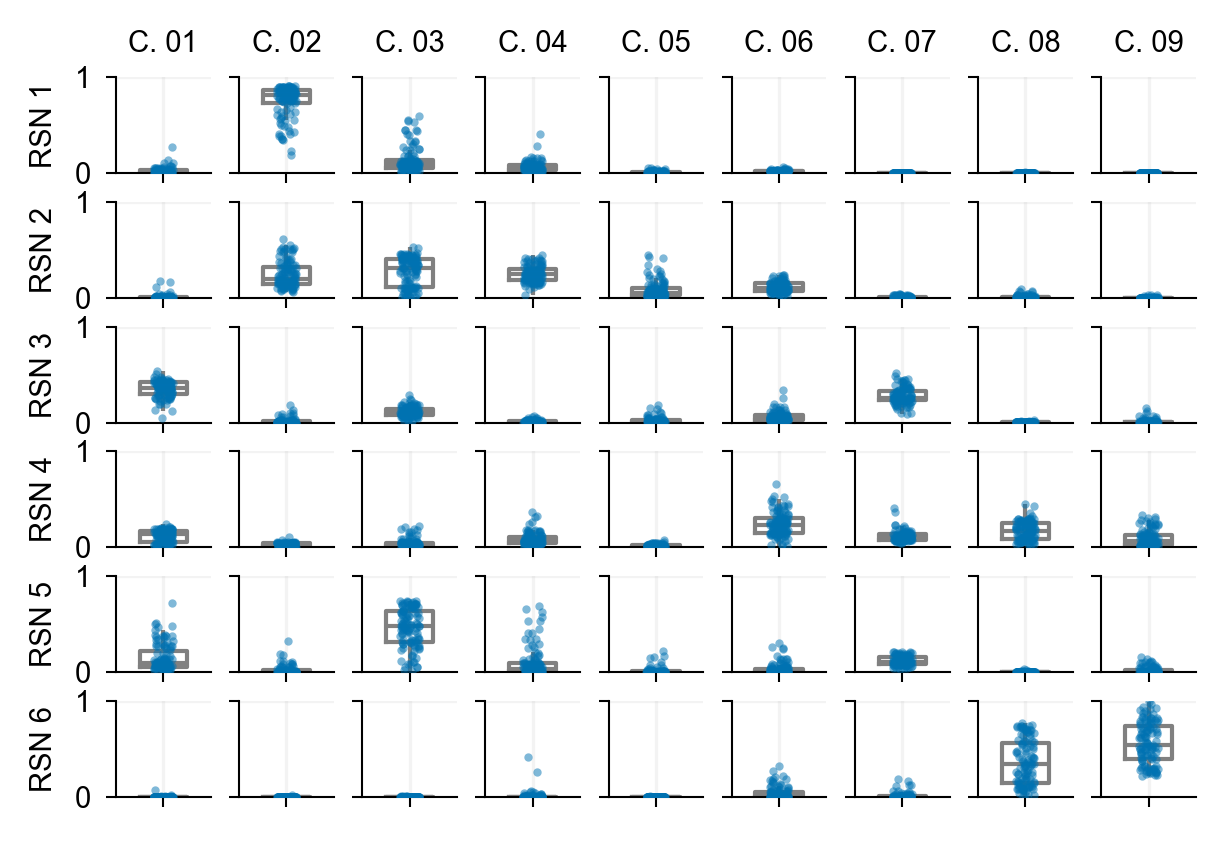

In [39]:
folder = f'{ESTIM_path}/group/resemblance-to-rsns/{SBM}'
os.makedirs(folder, exist_ok=True)

for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    long_df = make_tidy(soft_coverage_df, col)
    g = plot_coverages(long_df)
    g.savefig(f'{folder}/level-{level}_desc-coverages.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/level-{level}_desc-coverages.png', transparent=True, dpi=300, bbox_inches='tight')

effective number of comms. that cover an RSN

In [40]:
def eff_num_comms(U):
    Ers = np.exp(stats.entropy(U, axis=0))
    Ers = np.nan_to_num(Ers)[None, :]
    return Ers

In [41]:
eff_num_comms_df = pd.concat(
    [
        coverage_df[['sub', 'sbm', 'omega']],
        coverage_df[cols].applymap(lambda U: eff_num_comms(U)),
    ],
    axis=1,
)

soft_eff_num_comms_df = get_soft_estim_df(eff_num_comms_df)

soft_eff_num_comms_df

,sub,sbm,pi_0_aligned,pi_1_aligned,pi_2_aligned,pi_3_aligned,pi_4_aligned,pi_5_aligned,pi_6_aligned,pi_7_aligned,pi_8_aligned
0,00,sbm-nd-h,"[[2.89555976037764, 5.125394727442868, 6.66989...","[[2.139592116407108, 3.527936619132392, 3.4537...","[[1.5804196448964747, 2.0388673345883728, 2.57...","[[1.204475170917034, 1.226063974037989, 1.2564...","[[1.030802154436894, 1.0389222196302044, 1.047...","[[1.0060643063000627, 1.0093330254775725, 1.01...","[[1.0036480454010956, 1.0054627561822467, 1.00...","[[1.0020324994944219, 1.0026026557050132, 1.00...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]"
1,01,sbm-nd-h,"[[4.577136657823438, 7.9124415346846755, 6.901...","[[3.8190912522840414, 4.084103367186633, 5.621...","[[1.524835734164027, 1.6505887744715289, 2.283...","[[1.1069485520850313, 1.1126148500875073, 1.17...","[[1.0079386000168544, 1.0079386000168544, 1.01...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]"
2,02,sbm-nd-h,"[[3.1994524267663866, 5.118398961515823, 6.765...","[[1.5119990513656856, 2.7264450470170423, 3.77...","[[1.5594142820895738, 1.7127974770209164, 1.85...","[[1.0772294753500744, 1.0854833125577554, 1.11...","[[1.023892559548201, 1.0261874883271564, 1.026...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]"
3,03,sbm-nd-h,"[[2.74834213504161, 4.871261555374158, 5.71010...","[[1.4736966264559985, 2.65981886447416, 4.1595...","[[1.9568990402998285, 2.631654458278963, 3.123...","[[1.1990390690300747, 1.2264408964415474, 1.24...","[[1.0357788503875378, 1.0401645611955672, 1.04...","[[1.00533845871195, 1.00533845871195, 1.005439...","[[1.0000000000000002, 1.0000000000000002, 1.00...","[[1.0000000000000002, 1.0000000000000002, 1.00...","[[1.0000000000000002, 1.0000000000000002, 1.00..."
4,04,sbm-nd-h,"[[3.111313847720405, 5.058385367904012, 7.3742...","[[1.9956902726916539, 4.888696580352019, 4.753...","[[2.153452974357697, 2.1455772299304123, 2.625...","[[1.1682067344997864, 1.1525202765114646, 1.19...","[[1.047586257278791, 1.0475449536583945, 1.050...","[[1.01592518589419, 1.0079386000168544, 1.0145...","[[1.0, 1.0, 1.0079386000168544, 1.0, 1.0, 1.00...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]"
...,...,...,...,...,...,...,...,...,...,...,...
106,84,sbm-nd-h,"[[3.0775932541251985, 5.060447466860916, 6.365...","[[2.6907138858140804, 4.497096003680701, 3.604...","[[1.3356458705778163, 1.9130794608105284, 2.37...","[[1.2138207501160023, 1.2248115638922221, 1.23...","[[1.0656205414768012, 1.05592915329634, 1.0545...","[[1.0261102576993881, 1.022361717353593, 1.020...","[[1.0100666739985564, 1.0093089895641387, 1.00...","[[1.005697471468614, 1.004449342975767, 1.0031...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]"
107,85,sbm-nd-h,"[[2.871760682757119, 5.071821987370945, 6.4320...","[[2.205034271511198, 3.5988898424095987, 3.245...","[[1.4653504611659531, 1.703784541074615, 2.162...","[[1.1686001504558687, 1.1859305887433043, 1.21...","[[1.038622713751422, 1.0438115242080124, 1.049...","[[1.0043715015105672, 1.004905890304331, 1.007...","[[1.0014515329942224, 1.0007929608331847, 1.00...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]"
108,87,sbm-nd-h,"[[3.333384969572726, 6.128968490849524, 6.3870...","[[2.3408273545069536, 4.0916047622710146, 4.68...","[[1.461331556552754, 1.5347744898237539, 1.912...","[[1.1387102594698686, 1.1363924146963154, 1.15...","[[1.0213194376418187, 1.0218140371950974, 1.02...","[[1.0042042865367977, 1.0042042865367977, 1.00...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]"
109,89,sbm-nd-h,"[[3.5028109349596543, 4.994207934511483, 6.489...","[[2.2827531962901966, 3.8633953579954152, 3.58...","[[1.6909713570719287, 1.9748506695688484, 2.40...","[[1.1695730636885444, 1.1815018843291754, 1.18...","[[1.0205547192644544, 1.0224

In [42]:
def plot_eff_num_comms(long_df: pd.DataFrame, ):
    nrows = sorted(long_df['j'].unique())
    nrows = len(nrows)
    ncols = 1

    height = 0.5 #inches
    aspect = 1
    width = height * aspect

    fig_height = height * nrows
    fig_width = width * ncols

    fig, axs = plt.subplots(
        nrows, ncols, 
        figsize=(fig_width, fig_height), 
        sharey=False,
    )
    # Manually set the spacing. Values are fractions of the figure dimensions.
    # This guarantees identical spacing for every figure you create this way.
    fig.subplots_adjust(
        left=0.1,    # Increase if y-axis labels are cut off
        right=0.9,   # Decrease if there's too much margin on the right
        bottom=0.1,  # Increase if x-axis labels are cut off
        top=0.9,     # Decrease if titles are cut off
        wspace=0.3, # Width between subplots
        hspace=0.3,   # Height between subplots
    )

    for (i, j), group in long_df.groupby(by=['i', 'j']):
        
        ax = axs[j, i] if ncols > 1 else axs[j]
        
        sns.boxplot(
            group, 
            ax=ax,
            y='value',
            color='grey',
            fill=False,
            width=0.5,
            linewidth=1,
            fliersize=0,
            capprops=dict(linewidth=0),
        )
        
        sns.stripplot(
            group, 
            ax=ax, 
            y='value',
            color=CUD_COLORS[0],
            size=2,
            marker='o',
            alpha=0.5,
            jitter=True,
        )
        
        ax.grid(alpha=0.15)
        ax.set(ylabel=f'RSN {j+1}') #, ylim=[1, 5], yticks=[1, 2, 3, 4, 5], xlabel=None, ylabel=None)
        # ax.set(ylim=[1, 10], yticks=[1, 5, 9])
        sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
    return fig

pi_1_aligned


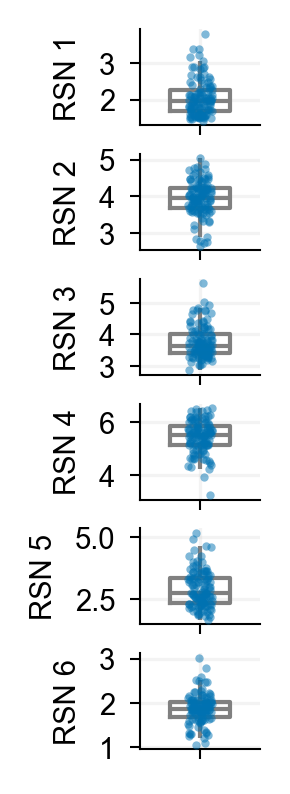

In [43]:
folder = f'{ESTIM_path}/group/resemblance-to-rsns/{SBM}'
os.makedirs(folder, exist_ok=True)

for col in cols[1:2]:
    print(col)
    level = col.replace('pi', '').replace('_', '').replace('aligned', '')
    long_df = make_tidy(soft_eff_num_comms_df, col)
    g = plot_eff_num_comms(long_df)
    g.savefig(f'{folder}/level-{level}_desc-eff-num-comms.svg', transparent=True, dpi=300, bbox_inches='tight')
    g.savefig(f'{folder}/level-{level}_desc-eff-num-comms.png', transparent=True, dpi=300, bbox_inches='tight')

---

<Axes: >

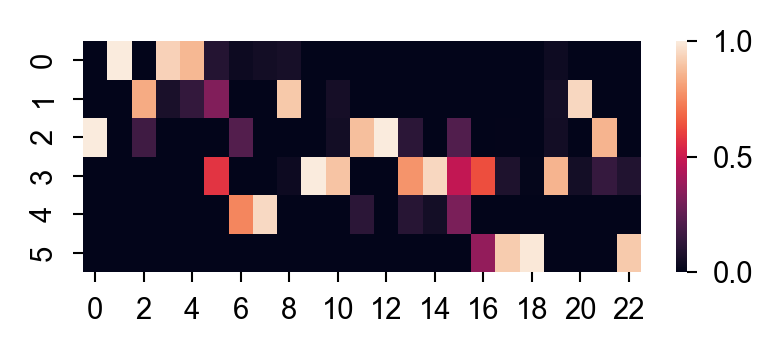

In [44]:
S = specificity_df.at[0, cols[0]]
fig, ax = plt.subplots(1, 1, figsize=(3, 1))
sns.heatmap(S, ax=ax)

---
---

In [45]:
# import ptitprince as pt
# import seaborn as sns
# import matplotlib.pyplot as plt

# def half_violin(data, **kwargs):
#     ax = plt.gca()
#     pt.RainCloud(x='sample', y='value', data=data, half_violin=True, ax=ax)

# # Assuming long_df has columns 'i', 'j', 'value', 'sample'

# g = sns.FacetGrid(long_df, row='i', col='j')
# g.map_dataframe(half_violin)
